In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")

include("/Users/ryansenne/Documents/GitHub/SSM//src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots
using CSV
using DataFrames

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`

In [2]:
# Generate data from a known dynamical system--a pendulum
g = 9.81 # gravity
l = 1.0 # length of pendulum
dt = 0.001 # time step
T = 0.004 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 1.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end

# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 1e-8 * I(2)  # Process noise covariance
R = 0.25 * I(2)  # Observation noise covariance
P0 = 1e-2 * I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))

# Run the Kalman filter
x_filt, p_filt, x_pred, p_pred, v, F, K, ll = KalmanFilter(kf, Matrix{Float64}(x_noisy'))
# Run the smoother
x_smooth, P_smooth = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([0.021095946893374354 0.9880725292189211; 0.02208404040132588 0.9878655660314476; … ; 0.024059575483862977 0.9874225348492283; 0.025046995445026518 0.9871865010614396], [0.008619969730751385 2.6185984578416014e-5; 0.00862003796404374 -4.97553040217503e-5; … ; 0.008619720856402353 -0.00020163372946618057; 0.008619335525656972 -0.000277564930828126;;; 2.6185984578415922e-5 0.00862081896490984; -4.975530402175039e-5 0.008621141989231815; … ; -0.00020163372946618066 0.008626260007280657; -0.00027756493082812606 0.008631054898887087], [0.9999891900392412 0.009809885144475493; 0.9999891497973595 0.009809875588047162; … ; 0.9999890687596155 0.009809855415709275; 1.0 1.0;;; -0.0009999979998486334 0.9999891900392411; -0.0010000071214529768 0.9999891499878236; … ; -0.0010000264187554342 0.9999890699328084; 1.0 1.0])

In [3]:
# calculate the predictions of X
using Profile
x_prediction = zeros(length(t), 2)
x_prediction[1, :] = kf.x0
for t in 2:length(t)
    x_prediction[t, :] = kf.A * x_prediction[t-1, :]
end

@profile x_new = SSM.newton_raphson_tridg!(kf, x_prediction, x_noisy', 10, 1e-3)

Norm of gradient iterate difference: 0.05279246461986662
Converged at iteration 2


5×2 Matrix{Float64}:
 0.020394   0.988468
 0.0213825  0.988268
 0.0223707  0.988058
 0.0233588  0.987839
 0.0243466  0.98761

In [5]:
Profile.view()

MethodError: MethodError: no method matching view()

Closest candidates are:
  view(!Matched::LinRange, !Matched::OrdinalRange{<:Integer})
   @ Base subarray.jl:206
  view(!Matched::Base.OneTo, !Matched::Base.OneTo)
   @ Base subarray.jl:186
  view(!Matched::DataFrameRow, !Matched::Colon)
   @ DataFrames C:\Users\ryansenne\.julia\packages\DataFrames\58MUJ\src\dataframerow\dataframerow.jl:325
  ...


In [4]:
grad = SSM.Gradient(kf, x_noisy', x_new)
grad = reshape(grad', 10, 1)

10×1 reshape(adjoint(::Matrix{Float64}), 10, 1) with eltype Float64:
 -4.078266613305459e-10
  2.1697834640121982e-9
 -3.923590341514682e-10
 -1.357652834599321e-8
 -2.2880541905578866e-10
  1.9271966689160536e-8
 -1.1188725501654062e-9
  3.278558091679429e-9
  4.222076022131205e-10
 -9.925791299991715e-9

In [6]:
norm(grad)

0.03524279122366052

In [5]:
using ForwardDiff
# H = ForwardDiff.hessian(x -> SSM.loglikelihood(x', kf, x_noisy[1:2, 1:100]'), x_prediction')
G = ForwardDiff.gradient(x -> SSM.loglikelihood(x', kf, x_noisy'), x_new')
G = reshape(G, 10, 1)

10×1 Matrix{Float64}:
 -4.078266613305459e-10
  2.169784352190618e-9
 -3.923590341514682e-10
 -1.3576527901904001e-8
 -2.2880541905578866e-10
  1.9271966689160536e-8
 -1.1188725501654062e-9
  3.278558091679429e-9
  4.222076022131205e-10
 -9.925791299991715e-9

In [21]:
findmax(G)

(4.3185945042267804e-8, CartesianIndex(1942, 1))

In [18]:
norm(G)

3.160698083160009e-7

0.16834225682229392Iteration: 1


5×2 Matrix{Float64}:
 -0.0403536  0.935735
 -0.0394179  0.93613
 -0.0384818  0.936517
 -0.0375454  0.936895
 -0.0366085  0.937263

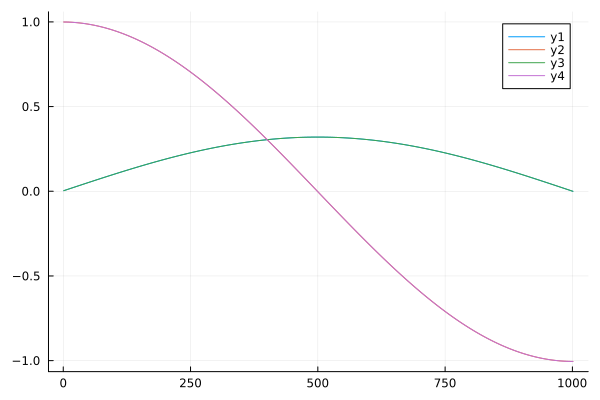

In [4]:
plot(x_new[:, 1])
plot!(x_new[:, 2])
plot!(x_smooth[:, 1])
plot!(x_smooth[:, 2])

In [15]:
plot(x_new[:, 1])
# plot!(x_new[:, 2])
plot!(x_smooth[:, 1])
# plot!(x_smooth[:, 2])

UndefVarError: UndefVarError: `x_new` not defined

In [16]:
plot(x_smooth - x_prediction)
plot!(-z[1:2:end])
plot!(-z[2:2:end])



UndefVarError: UndefVarError: `z` not defined

In [17]:
# need to use previously aquired pendulum data for comparison
pendulum_data = CSV.read("/Users/ryansenne/Documents/GitHub/SSM/notebooks/pendulum_data_1.csv", DataFrame)

# convert x_noisy columns to matrix for use 
x_noisy =  Matrix(pendulum_data[:, 3:4])

# now create a Kalman Filter where we want to learn the parameters
A = [0.1 0.2; 0.3 0.4]
H = [0.5 0.5; 0.5 0.5]
Q = 0.1 * I(2)
R = 1.0 * I(2)
p0 = 1.0 * I(2)
x0 = [0.0, 0.0]

# kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))
kf_unknown = LDS(A, H, nothing, Q, R, x0, p0, nothing, 2, 2, "Gaussian", [true, true, true, true, true, true, true, true, true])
# SSM.pca_init!(kf_unknown, x_noisy)

# SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy), 10)

LDS([0.1 0.2; 0.3 0.4], [0.5 0.5; 0.5 0.5], nothing, [0.1 0.0; 0.0 0.1], [1.0 0.0; 0.0 1.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], nothing, 2, 2, "Gaussian", Bool[1, 1, 1, 1, 1, 1, 1, 1, 1])